Youtube Video: [TensorFlow Course – Building and Evaluating Medical AI Models](https://www.youtube.com/watch?v=8m3LvPg8EuI)

In [1]:
# Enable inline plotting (for Colab/Jupyter)
%matplotlib inline

# Imports — Standard Libraries
import os
import io
import glob
import random
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import matplotlib.image as mpimg
import matplotlib
from PIL import Image, ImageDraw, ImageFont
from six import BytesIO
from scipy import misc

# Imports — TensorFlow & Keras
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model

# Imports — Scikit-learn
import sklearn.metrics

# Global Configuration
LEARNING_RATE = 0.0001
IMAGE_HEIGHT, IMAGE_WIDTH = 299, 299

# Repository containing data or scripts
repo_url = 'https://github.com/adleberg/medical-ai'

# Convert a PIL image into a NumPy array. Ensures RGB format and returns a (height, width, 3) uint8 array.
def load_image_into_numpy_array(image):
    image = image.convert('RGB')
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)

# GitHub Repository Setup
%cd -q /content

# Clone repository
repo_dir_path = os.path.abspath(os.path.join('.', os.path.basename(repo_url)))
!git clone {repo_url} --quiet

# Navigate to repo directory
%cd -q {repo_dir_path}

# Pull latest changes
!git pull -q

# Install External Dependencies
!apt-get install -y graphviz
!pip install -q pydot

/tmp/ipython-input-2729149354.py:18: DeprecationWarning: scipy.misc is deprecated and will be removed in 2.0.0
  from scipy import misc


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.


In [2]:
df = pd.read_csv("/content/medical-ai/labels.csv")
df.head()

,filename,height,width,label,xmin,ymin,xmax,ymax,view
0,00013118_008.jpg,2992,2991,Atelectasis,225.0,547.0,311.0,626.0,PA
1,00014716_007.jpg,3056,2544,Atelectasis,686.0,131.0,871.0,444.0,AP
2,00029817_009.jpg,3056,2544,Atelectasis,221.0,317.0,376.0,533.0,AP
3,00014687_001.jpg,2500,2048,Atelectasis,726.0,494.0,867.0,549.0,AP
4,00017877_001.jpg,2500,2048,Atelectasis,660.0,569.0,860.0,647.0,AP


In [3]:
# Filter the dataset to separate images with 'Cardiomegaly' from normal cases
finding = "Cardiomegaly"
positives = df.loc[df["label"] == finding]
negatives = df.loc[df["label"] == "No Finding"]
print(len(positives))

146


In [4]:
# Split the positive samples into training and testing sets
train_ratio = 0.8
test_ratio = 0.2
count = len(positives)
train_count = int(count * train_ratio)
test_count = int(count * test_ratio)
print("Training Samples: ", train_count, "\nTesting Samples: ", test_count)

Training Samples:  116 
Testing Samples:  29


In [5]:
# Create balanced training and testing label sets by combining positive and negative samples
train_labels = pd.concat([positives[:train_count], negatives[:train_count]])
test_labels = pd.concat([positives[train_count:], negatives[train_count:count]])

In [6]:
# Create directory structure for organizing training and testing images into positive and negative classes
rootdir = "/content/medical-ai/images/"
os.makedirs(rootdir + finding + "/test/positive",  exist_ok=True)
os.makedirs(rootdir + finding + "/test/negative",  exist_ok=True)
os.makedirs(rootdir + finding + "/train/positive", exist_ok=True)
os.makedirs(rootdir + finding + "/train/negative", exist_ok=True)


In [7]:
# Copy positive and negative images into their respective training and testing folders based on the defined split
for idx, image in positives[:train_count].iterrows():
    source = rootdir + image["filename"]
    dst = rootdir + finding + "/train/positive/" + image["filename"]
    shutil.copy(source, dst)

for idx, image in positives[train_count:].iterrows():
    source = rootdir + image["filename"]
    dst = rootdir + finding + "/test/positive/" + image["filename"]
    shutil.copy(source, dst)

for idx, image in negatives[:train_count].iterrows():
    source = rootdir + image["filename"]
    dst = rootdir + finding + "/train/negative/" + image["filename"]
    shutil.copy(source, dst)

for idx, image in negatives[train_count:count].iterrows():
    source = rootdir + image["filename"]
    dst = rootdir + finding + "/test/negative/" + image["filename"]
    shutil.copy(source, dst)

print("Done moving " + str(count * 2) + " images to positive and negative folders.")

Done moving 292 images to positive and negative folders.


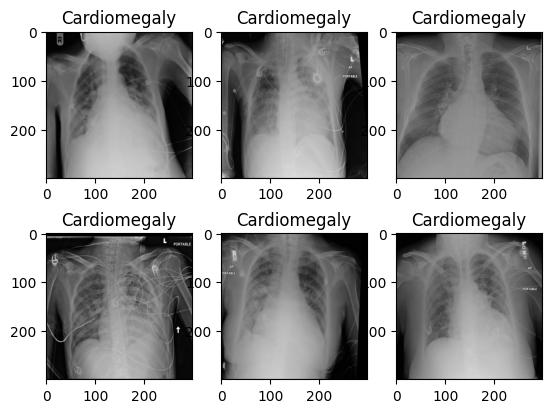

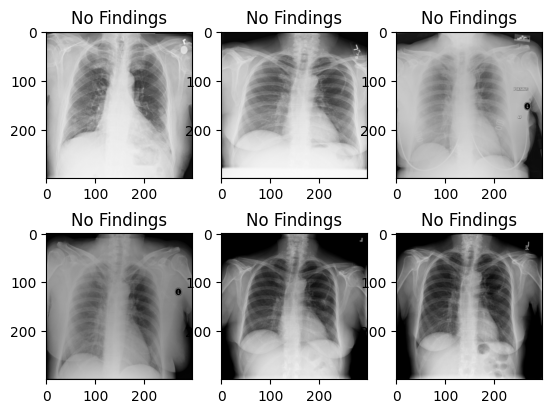

In [8]:
# Load and resize sample positive and negative images to visually compare the two classes
from PIL import Image, ImageDraw, ImageFont

positive_imgs, negative_imgs = [], []
IMAGE_HEIGHT, IMAGE_WIDTH = 299, 299

for idx, row in positives[:6].iterrows():
    image_path = rootdir + row["filename"]
    image = Image.open(image_path).resize((IMAGE_WIDTH, IMAGE_HEIGHT))
    positive_imgs.append(load_image_into_numpy_array(image))

for idx, row in negatives[:6].iterrows():
    image_path = rootdir + row["filename"]
    image = Image.open(image_path).resize((IMAGE_WIDTH, IMAGE_HEIGHT))
    negative_imgs.append(load_image_into_numpy_array(image))

for idx, img in enumerate(positive_imgs[:6]):
  plt.subplot(2, 3, idx+1)
  plt.title(finding)
  plt.imshow(positive_imgs[idx])
plt.show()

for idx, img in enumerate(negative_imgs[:6]):
  plt.subplot(2, 3, idx+1)
  plt.title("No Findings")
  plt.imshow(negative_imgs[idx])

plt.show()


In [9]:
# Define directory paths for training and testing datasets
base_dir = rootdir = "/content/medical-ai/images/"
train_dir = os.path.join(base_dir, finding, 'train')
test_dir = os.path.join(base_dir, finding, 'test')

train_pos_dir = os.path.join(train_dir, 'positive')
train_neg_dir = os.path.join(train_dir, 'negative')
test_pos_dir = os.path.join(test_dir, 'positive')
test_neg_dir = os.path.join(test_dir, 'negative')

In [10]:
# Load training and validation image datasets from directory structure with batching, resizing, and shuffling
batch_size = 64
img_size = (299, 299)
img_shape = img_size + (3,)

train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    shuffle=True,
    batch_size=batch_size,
    image_size=img_size
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    shuffle=True,
    batch_size=batch_size,
    image_size=img_size
)


Found 232 files belonging to 2 classes.
Found 60 files belonging to 2 classes.


In [11]:
# Load the pre-trained InceptionV3 model (without the top classification layer) and freeze its weights for feature extraction
base_model = tf.keras.applications.InceptionV3(
    input_shape=img_shape,
    include_top=False,
    weights='imagenet'
)

base_model.trainable = False

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [12]:
# Define a data augmentation pipeline to introduce random variations and improve model generalization
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.10),          # Randomly rotate images
    tf.keras.layers.RandomTranslation(0.05, 0.05), # Randomly shift images horizontally and vertically
    tf.keras.layers.RandomContrast(0.1),           # Randomly adjust image contrast
    tf.keras.layers.RandomBrightness(0.1),         # Randomly adjust image brightness
    tf.keras.layers.RandomZoom(0.1, 0.1)           # Randomly zoom in or out
])

In [13]:
# Build and compile the full transfer learning model using InceptionV3 as the base and custom classification layers on top
inputs = tf.keras.Input(shape=img_shape)
x = data_augmentation(inputs)                               # Apply data augmentation dynamically during training
x = tf.keras.applications.inception_v3.preprocess_input(x)  # Normalize images for InceptionV3
x = base_model(x, training=False)                           # Use the pre-trained base model (frozen)
x = tf.keras.layers.GlobalAveragePooling2D()(x)             # Reduce feature maps to a single vector per image
x = tf.keras.layers.Dropout(0.5)(x)                         # Add dropout for regularization
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x) # Final binary classification output layer

# Define the complete model
model = tf.keras.Model(inputs, outputs)

# Compile the model with Adam optimizer, binary cross-entropy loss, and accuracy metric
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='binary_crossentropy',
    metrics=['accuracy']
)


In [14]:
# Define an early stopping callback to prevent overfitting by stopping training when validation loss stops improving
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',          # Track validation loss during training
    patience=5,                  # Stop after 5 epochs with no improvement
    restore_best_weights=True    # Restore the best model weights from before performance declined
)

In [15]:
# Set the number of epochs for initial training
initial_epochs = 20

# Train the model with early stopping
history = model.fit(
    train_dataset,
    epochs=initial_epochs,
    validation_data=validation_dataset,
    callbacks=[early_stopping]
)

Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/step - accuracy: 0.4463 - loss: 0.8270 - val_accuracy: 0.4000 - val_loss: 0.7291
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 447ms/step - accuracy: 0.5578 - loss: 0.7547 - val_accuracy: 0.5000 - val_loss: 0.7215
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 443ms/step - accuracy: 0.5631 - loss: 0.7565 - val_accuracy: 0.5000 - val_loss: 0.6950
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 651ms/step - accuracy: 0.4913 - loss: 0.7812 - val_accuracy: 0.5500 - val_loss: 0.6833
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 457ms/step - accuracy: 0.5126 - loss: 0.7400 - val_accuracy: 0.5333 - val_loss: 0.6782
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 785ms/step - accuracy: 0.5571 - loss: 0.6954 - val_accuracy: 0.5667 - val_loss: 0.6679
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 590ms/step - accuracy: 0.5852 - loss: 0.6849 - val_accuracy: 0.5833 - val_loss: 0.6646
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 568ms/step - accuracy: 0.6297 - loss: 0.6700 - val_accuracy: 0.5667 - val_loss: 0

In [16]:
# Unfreeze the base model for fine-tuning
base_model.trainable = True

# Set the layer index to start fine-tuning from
fine_tune_at = 249  # InceptionV3-specific (out of ~311 layers)

# Freeze all layers before 'fine_tune_at' to retain pretrained weights
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Recompile with a lower learning rate for smoother fine-tuning
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Define fine-tuning parameters
fine_tune_epochs = 40
total_epochs = initial_epochs + fine_tune_epochs  # Combine initial + fine-tune

# Continue training with fine-tuning enabled
history_fine = model.fit(
    train_dataset,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],  # Resume from previous training
    validation_data=validation_dataset,
    callbacks=[early_stopping]  # Stop early if no improvement
)


Epoch 20/60
4/4 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.5246 - loss: 0.7998 - val_accuracy: 0.6500 - val_loss: 0.5760
Epoch 21/60
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 522ms/step - accuracy: 0.5142 - loss: 0.7242 - val_accuracy: 0.6667 - val_loss: 0.5714
Epoch 22/60
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 527ms/step - accuracy: 0.5756 - loss: 0.7227 - val_accuracy: 0.7167 - val_loss: 0.5668
Epoch 23/60
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 527ms/step - accuracy: 0.5729 - loss: 0.6692 - val_accuracy: 0.6833 - val_loss: 0.5613
Epoch 24/60
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 528ms/step - accuracy: 0.5876 - loss: 0.6788 - val_accuracy: 0.6833 - val_loss: 0.5554
Epoch 25/60
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 798ms/step - accuracy: 0.5991 - loss: 0.6587 - val_accuracy: 0.7167 - val_loss: 0.5485
Epoch 26/60
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 528ms/step - accuracy: 0.6746 - loss: 0.6017 - val_accuracy: 0.7167 - val_loss: 0.5408
Epoch 27/60
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 529ms/step - accuracy: 0.6551 - loss: 0.5854 - val_accuracy: 0.7000 - val

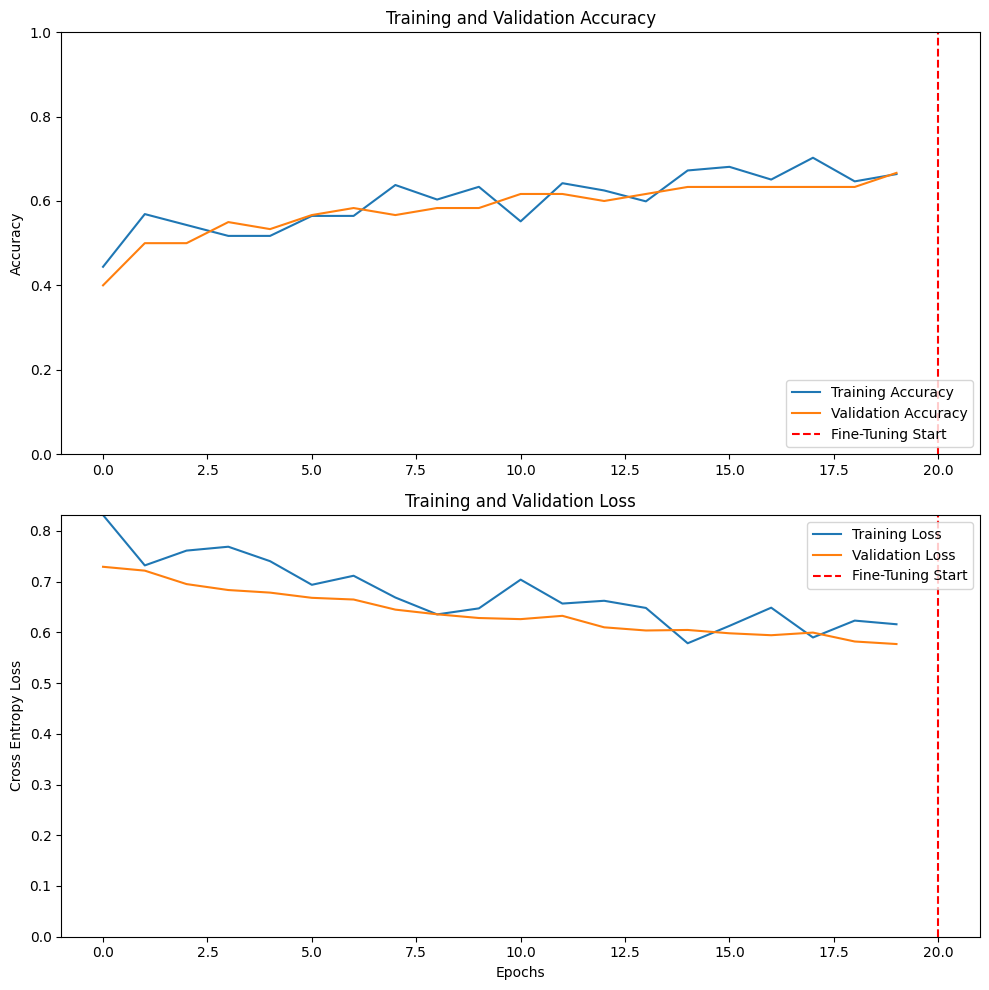

In [17]:
 # Combine training histories from initial training and fine-tuning, then visualize accuracy and loss trends over all epochs
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Total epochs and the point where fine-tuning begins
total_epochs = len(acc)
fine_tune_start = initial_epochs

plt.figure(figsize=(10, 10))

# Accuracy plot
plt.subplot(2, 1, 1)
plt.plot(range(total_epochs), acc, label='Training Accuracy')
plt.plot(range(total_epochs), val_acc, label='Validation Accuracy')
plt.axvline(x=fine_tune_start, color='r', linestyle='--', label='Fine-Tuning Start')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.title('Training and Validation Accuracy')

# Loss plot
plt.subplot(2, 1, 2)
plt.plot(range(total_epochs), loss, label='Training Loss')
plt.plot(range(total_epochs), val_loss, label='Validation Loss')
plt.axvline(x=fine_tune_start, color='r', linestyle='--', label='Fine-Tuning Start')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy Loss')
plt.ylim([0, max(max(loss), max(val_loss))])
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')

plt.tight_layout()
plt.show()

In [18]:
# Predict the probability of the positive class for a given image file
def predict_image(filename):
    image = Image.open(filename).resize((IMAGE_HEIGHT, IMAGE_WIDTH))
    image_np = load_image_into_numpy_array(image)
    expanded = np.expand_dims(image_np, axis=0)
    return model.predict(expanded)[0][0]

# Display an image from a DataFrame row along with its true label and model prediction
def show_df_row(row):
    image_path = row["filepath"]
    image = Image.open(image_path).resize((IMAGE_WIDTH, IMAGE_HEIGHT))
    img = load_image_into_numpy_array(image)
    expanded = np.expand_dims(img, axis=0)
    pred = model.predict(expanded)[0][0]
    guess = "neg"
    if pred > 0.5:
        guess = "pos"
    title = "Image: " + row["filename"] + " Label: " + row["label"] + " Guess: " + guess + " Score: " + str(pred)
    plt.title(title)
    plt.imshow(img)
    plt.show()
    return


In [19]:
# Run inference on all test images (positive and negative), record predictions and confidence scores, and store results in a DataFrame
results = []

# Process negative test images
for image in os.listdir(test_neg_dir):
    filename = test_neg_dir + "/" + image
    confidence = predict_image(filename)
    guess = 'pos' if confidence > 0.5 else 'neg'
    results.append([filename, image, "neg", guess, confidence])

# Process positive test images
for image in os.listdir(test_pos_dir):
    filename = test_pos_dir + "/" + image
    confidence = predict_image(filename)
    guess = 'pos' if confidence > 0.5 else 'neg'
    results.append([filename, image, "pos", guess, confidence])

# Sort results by confidence score (highest first) and create a DataFrame
sorted_results = sorted(results, key=lambda x: x[4], reverse=True)
df = pd.DataFrame(data=sorted_results, columns=["filepath", "filename", "label", "guess", "confidence"])

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


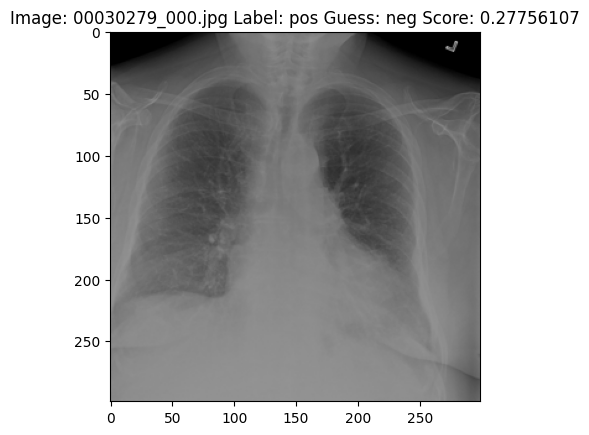

In [20]:
# Randomly select a row from the results DataFrame and display the corresponding image with its true label and model prediction
import random

n = random.randint(0, len(df) - 1)
show_df_row(df.iloc[n])

In [21]:
# Display every 5th row from the DataFrame, showing filename, true label, predicted label, and confidence score
df[::5][['filename', 'label', 'guess', 'confidence']]

,filename,label,guess,confidence
0,00030206_013.jpg,pos,pos,0.981145
5,00011557_003.jpg,pos,pos,0.905452
10,00001373_009.jpg,pos,pos,0.867762
15,00004342_023.jpg,pos,pos,0.773664
20,00025969_000.jpg,pos,pos,0.709609
25,00004344_013.jpg,pos,pos,0.667377
30,00000091_007.jpg,neg,pos,0.546184
35,00000080_003.jpg,neg,neg,0.454822
40,00000086_000.jpg,neg,neg,0.297810
45,00000078_000.jpg,neg,neg,0.156426


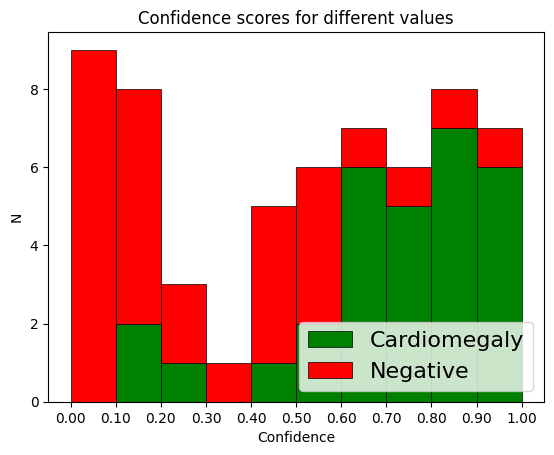

In [22]:
# Plot a stacked histogram of confidence scores for positive and negative test images to visualize model predictions
pos = df.loc[df['label'] == "pos"]["confidence"]
neg = df.loc[df['label'] == "neg"]["confidence"]

fig, ax = plt.subplots()
n, bins, patches = plt.hist(
    [pos, neg],
    np.arange(0.0, 1.1, 0.1).tolist(),
    edgecolor='black',
    linewidth=0.5,
    density=False,
    histtype='bar',
    stacked=True,
    color=['green', 'red'],
    label=[finding, 'Negative']
)

plt.xlabel('Confidence')
plt.ylabel('N')
plt.xticks(bins)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.title('Confidence scores for different values')
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [23]:
# Set the confidence threshold for classifying an image as positive
cutoff = 0.79  # Value between 0 and 1

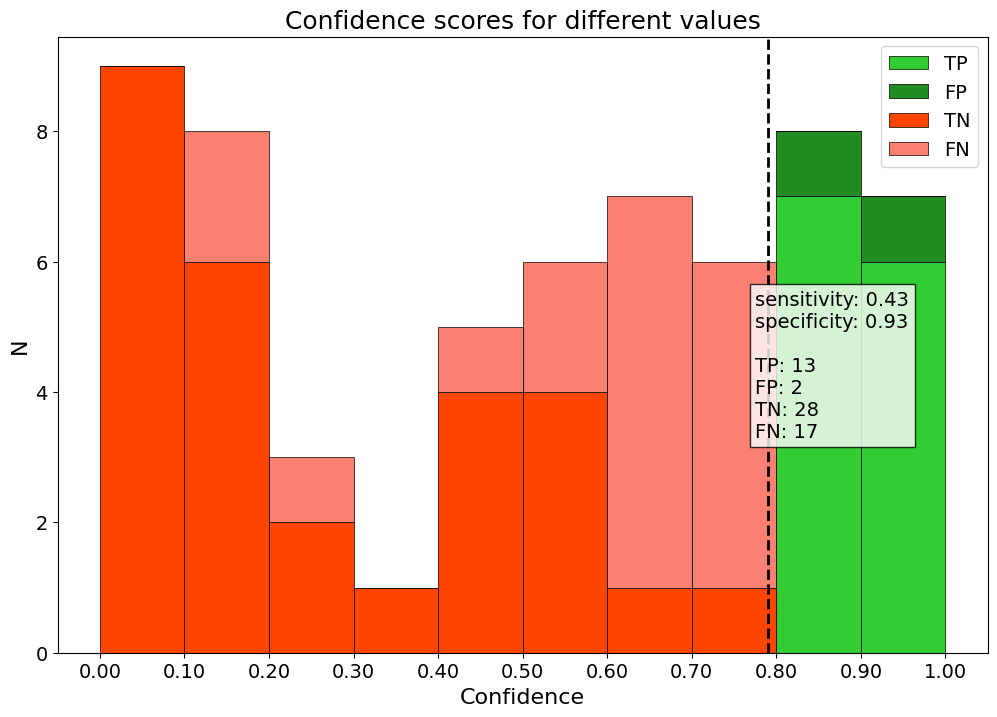

In [24]:
# Create a histogram of model predictions using a specified confidence cutoff and display corresponding TP, FP, TN, FN counts along with sensitivity and specificity
def create_with_cutoff(cutoff):
    __, ax = plt.subplots(figsize=(12, 8))  # Increased figure size

    # Separate predictions based on cutoff and true labels
    TP = df.loc[(df['label'] == "pos") & (df["confidence"] > cutoff)]["confidence"]
    FP = df.loc[(df['label'] == "neg") & (df["confidence"] > cutoff)]["confidence"]
    FN = df.loc[(df['label'] == "pos") & (df["confidence"] < cutoff)]["confidence"]
    TN = df.loc[(df['label'] == "neg") & (df["confidence"] < cutoff)]["confidence"]

    # Plot the histogram
    plt.hist([TP, FP, TN, FN], bins=np.arange(0.0, 1.1, 0.1).tolist(),
             edgecolor='black', linewidth=0.5, density=False, histtype='bar',
             stacked=True, color=['limegreen', 'forestgreen', 'orangered', 'salmon'],
             label=['TP', 'FP', 'TN', 'FN'])

    plt.xlabel('Confidence', fontsize=16)
    plt.ylabel('N', fontsize=16)
    plt.xticks(np.arange(0.0, 1.1, 0.1), fontsize=14)
    plt.yticks(fontsize=14)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    plt.title('Confidence scores for different values', fontsize=18)
    plt.axvline(cutoff, color='k', linestyle='dashed', linewidth=2)
    plt.legend(loc="upper right", fontsize=14)

    # Calculate and display sensitivity and specificity
    sens = round(len(TP) / (len(TP) + len(FN)), 2)
    spec = round(len(TN) / (len(TN) + len(FP)), 2)
    stats = f"sensitivity: {sens}\nspecificity: {spec}\n\nTP: {len(TP)}\nFP: {len(FP)}\nTN: {len(TN)}\nFN: {len(FN)}"

    plt.text(0.75, 0.35, stats, fontsize=14, transform=ax.transAxes,
             bbox=dict(facecolor='white', alpha=0.8, edgecolor='black'))

    plt.show()

create_with_cutoff(cutoff)

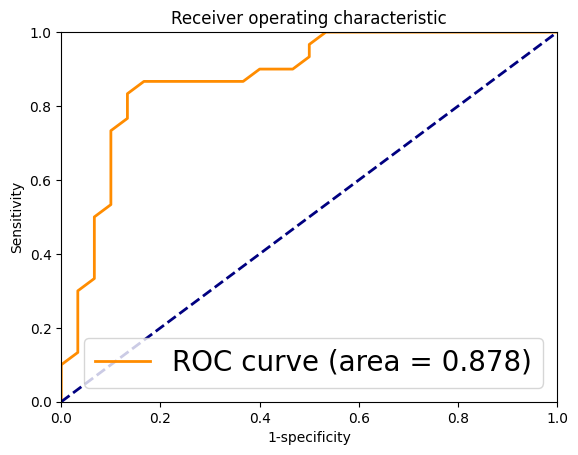

In [25]:
# Compute and plot the ROC curve by calculating sensitivity and specificity at each confidence threshold, and compute the AUC
def create_auc_curve(classifications):
    squares = {}
    # Calculate TP, FP, TN, FN for each unique confidence threshold
    for x in classifications:
        conf = x[4]
        TP, FP, TN, FN = 0, 0, 0, 0
        for row in classifications:
            assert (row[2] == "neg" or row[2] == "pos")
            if row[2] == "neg":
                if float(row[4]) < conf:
                    TN += 1
                else:
                    FP += 1
            else:
                if float(row[4]) > conf:
                    TP += 1
                else:
                    FN += 1
        squares[conf] = [TP, FP, TN, FN]

    # Convert counts to sensitivity and 1-specificity for ROC
    sens_spec = {}
    for entry in squares:
        sens = squares[entry][0] / float(squares[entry][0] + squares[entry][3])
        spec = squares[entry][2] / float(squares[entry][2] + squares[entry][1])
        sens_spec[entry] = (1 - spec, sens)
    return squares, sens_spec

# Generate the ROC data
squares, sens_spec = create_auc_curve(sorted_results)

# Extract points for plotting
x = []
y = []
for point in sens_spec.keys():
    x.append(sens_spec[point][0])
    y.append(sens_spec[point][1])

# Compute AUC
auc = sklearn.metrics.auc(x, y)

# Plot ROC curve
plt.figure()
lw = 2
plt.plot(x, y, color='darkorange', lw=lw, label='ROC curve (area = %0.3f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.ylabel('Sensitivity')
plt.xlabel('1-specificity')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right", fontsize=20)
plt.show()

In [26]:
# Export the trained model to a folder
model.export('/content/export/'+finding)
!zip -r /content/{finding}.zip /content/export/{finding}

Saved artifact at '/content/export/Cardiomegaly'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name='keras_tensor_311')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  139338810816848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139338810815312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139338810815696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139338810817808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139338810818000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139338928196688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139338928198224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139338928197072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139338928198608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139338928199184: TensorSpec(shape=(), dtype=tf.resource, name=None)
